<a href="https://colab.research.google.com/github/cwmarris/pull-request-monitor/blob/master/Income_LifeExpectancy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does Income Influence Life Expectancy?  
**Business Statistics Project — Reproducible Notebook**  
*Generated on August 09, 2025*

This notebook fetches **latest available** public data for the **United States (state-level)** and **OECD countries (cross-country)** to test the hypothesis:

> **H1:** Higher median income is associated with higher life expectancy.  
> **H0:** No association between median income and life expectancy.

You will produce:
- Cleaned datasets (CSV),
- OLS regressions with robust standard errors,
- Visualizations: scatter + regression line with 95% CI, boxplots, density (hist) plots, residual diagnostics.

> **Note:** State-level life expectancy is typically published with a lag (e.g., 2021), while income is current (e.g., 2023). This timing mismatch is discussed as a limitation.


In [91]:

# (Optional) install packages if needed — run these if imports fail
# %pip install pandas numpy matplotlib statsmodels requests python-dateutil

import pandas as pd, numpy as np, requests, io, json, math
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option("display.max_columns", 100)
print("Libraries ready.")


def smart_read_tabular(url):
    import requests, io
    r = requests.get(url)
    ct = r.headers.get("Content-Type","").lower()
    content = io.BytesIO(r.content)
    if "excel" in ct or url.lower().endswith((".xls", ".xlsx")):
        return pd.read_excel(content)
    # Some StatLinks may deliver CSV with octet-stream
    try:
        return pd.read_csv(content)
    except Exception:
        content.seek(0)
        return pd.read_excel(content)


Libraries ready.


## Parameters & Statlink placeholders

In [92]:
import os
# --- Parameters you may customize ---
# OECD Statlink CSVs: Click the 'Statlink' under the figures on the OECD pages to get a direct CSV link,
# then paste them below.
OECD_MEDIAN_INCOME_CSV = "/content/outputs/Median_income_2023.xlsx"
OECD_LIFE_EXPECTANCY_CSV = "/content/outputs/Life_expectancy_2021.xlsx"

# Output paths
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
US_JOINED_CSV = os.path.join(OUT_DIR, "us_states_income_lifeexp.csv")
OECD_JOINED_CSV = os.path.join(OUT_DIR, "oecd_income_lifeexp.csv")

print("Set your OECD Statlink URLs before running the OECD section.")

Set your OECD Statlink URLs before running the OECD section.


## United States — Data acquisition

In [93]:

# --- US Median Household Income (ACS 1-year, 2023) ---
# API doc: https://api.census.gov/data/2023/acs/acs1.html
acs_url = "https://api.census.gov/data/2023/acs/acs1?get=B19013_001E,NAME&for=state:*"
acs_resp = requests.get(acs_url)
acs_tbl = pd.DataFrame(acs_resp.json()[1:], columns=["median_income","state","state_fips"])
acs_tbl["median_income"] = pd.to_numeric(acs_tbl["median_income"], errors="coerce")
acs_tbl = acs_tbl.dropna(subset=["median_income"])
acs_tbl = acs_tbl[["state","median_income"]]
acs_tbl.head()


,state,median_income
0,Alabama,62212
1,Alaska,86631
2,Arizona,77315
3,Arkansas,58700
4,California,95521


In [72]:
# --- US Life Expectancy by state (Total, latest available e.g., 2021) ---
# CDC data API (dataset it4f-frdc): https://data.cdc.gov/
cdc_url = "https://data.cdc.gov/resource/it4f-frdc.csv"
us_le = pd.read_csv(cdc_url)
us_le = us_le.rename(columns={"life_expectancy":"life_expectancy"})
us_le.head()

,area,sex,leb,se,quartile
0,Mississippi,Total,70.9,0.092,70.9 - 74.5
1,West Virginia,Total,71.0,0.117,70.9 - 74.5
2,Alabama,Total,72.0,0.069,70.9 - 74.5
3,Louisiana,Total,72.2,0.073,70.9 - 74.5
4,Kentucky,Total,72.3,0.071,70.9 - 74.5


## United States — Join & clean

In [73]:
# Merge income and life expectancy
# The life expectancy dataframe uses 'area' for state names, not 'state'
us = pd.merge(acs_tbl, us_le, left_on="state", right_on="area", how="inner").dropna()
us["log_income"] = np.log(us["median_income"])

# Add Census region mapping for boxplots
regions = {
 'Maine':'Northeast','New Hampshire':'Northeast','Vermont':'Northeast','Massachusetts':'Northeast',
 'Rhode Island':'Northeast','Connecticut':'Northeast','New York':'Northeast','Pennsylvania':'Northeast',
 'New Jersey':'Northeast','Ohio':'Midwest','Indiana':'Midwest','Illinois':'Midwest','Michigan':'Midwest',
 'Wisconsin':'Midwest','Minnesota':'Midwest','Iowa':'Midwest','Missouri':'Midwest','North Dakota':'Midwest',
 'South Dakota':'Midwest','Nebraska':'Midwest','Kansas':'Midwest','Delaware':'South','Maryland':'South',
 'District of Columbia':'South','Virginia':'South','West Virginia':'South','North Carolina':'South',
 'South Carolina':'South','Georgia':'South','Florida':'South','Kentucky':'South','Tennessee':'South',
 'Alabama':'South','Mississippi':'South','Arkansas':'South','Louisiana':'South','Oklahoma':'South',
 'Texas':'South','Montana':'West','Idaho':'West','Wyoming':'West','Colorado':'West','New Mexico':'West',
 'Arizona':'West','Utah':'West','Nevada':'West','Washington':'West','Oregon':'West','California':'West',
 'Alaska':'West','Hawaii':'West'
}
us["region"] = us["state"].map(regions)

us.to_csv(US_JOINED_CSV, index=False)
us.describe(include="all")

,state,median_income,area,sex,leb,se,quartile,log_income,region
count,153,153.000000,153,153,153.000000,153.000000,153,153.000000,153
unique,51,NaN,51,3,NaN,NaN,12,NaN,4
top,Alabama,NaN,Alabama,Total,NaN,NaN,67.7 - 71.8,NaN,South
freq,3,NaN,3,51,NaN,NaN,14,NaN,51
mean,NaN,77588.901961,NaN,NaN,76.032680,0.107275,NaN,11.245741,NaN
std,NaN,12817.635775,NaN,NaN,3.310546,0.060672,NaN,0.164426,NaN
min,NaN,54203.000000,NaN,NaN,67.700000,0.023000,NaN,10.900492,NaN
25%,NaN,69183.000000,NaN,NaN,74.100000,0.062000,NaN,11.144510,NaN
50%,NaN,74632.000000,NaN,NaN,76.100000,0.088000,NaN,11.220325,NaN
75%,NaN,86631.000000,NaN,NaN,78.500000,0.138000,NaN,11.369413,NaN


## United States — OLS regression (life expectancy on log income)

In [74]:
X = sm.add_constant(us["log_income"])
y = us["leb"]
mod = sm.OLS(y, X).fit(cov_type="HC1")  # robust SEs
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    leb   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     60.36
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           1.12e-12
Time:                        18:50:25   Log-Likelihood:                -369.55
No. Observations:                 153   AIC:                             743.1
Df Residuals:                     151   BIC:                             749.2
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.2816     16.635     -3.203      0.0

## United States — Visualizations

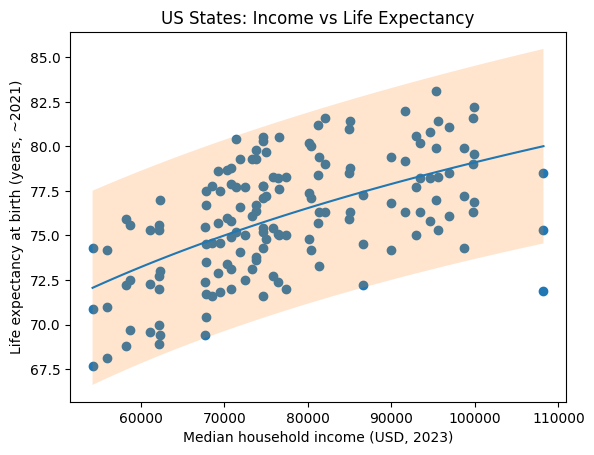

In [75]:
# Scatter + regression line with 95% CI (single plot)
xgrid = np.linspace(us["log_income"].min(), us["log_income"].max(), 100)
pred = mod.get_prediction(sm.add_constant(xgrid))
pred_df = pred.summary_frame(alpha=0.05)

plt.figure()
plt.scatter(us["median_income"], us["leb"])
x_income = np.exp(xgrid)
plt.plot(x_income, pred_df["mean"])
plt.fill_between(x_income, pred_df["obs_ci_lower"], pred_df["obs_ci_upper"], alpha=0.2)
plt.xlabel("Median household income (USD, 2023)")
plt.ylabel("Life expectancy at birth (years, ~2021)")
plt.title("US States: Income vs Life Expectancy")
plt.show()

<Figure size 640x480 with 0 Axes>

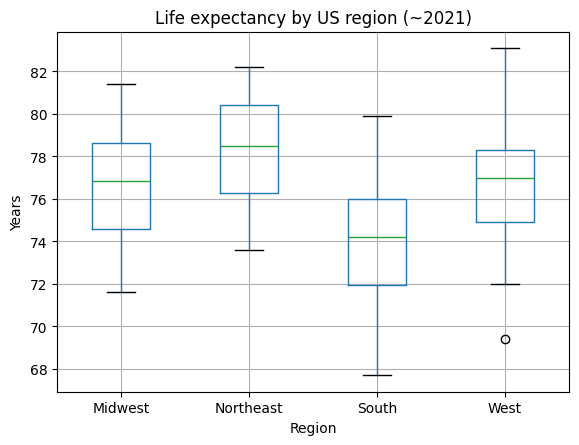

In [76]:
# Boxplot — life expectancy by region (single plot)
plt.figure()
us.boxplot(column="leb", by="region")
plt.suptitle("")
plt.title("Life expectancy by US region (~2021)")
plt.xlabel("Region")
plt.ylabel("Years")
plt.show()

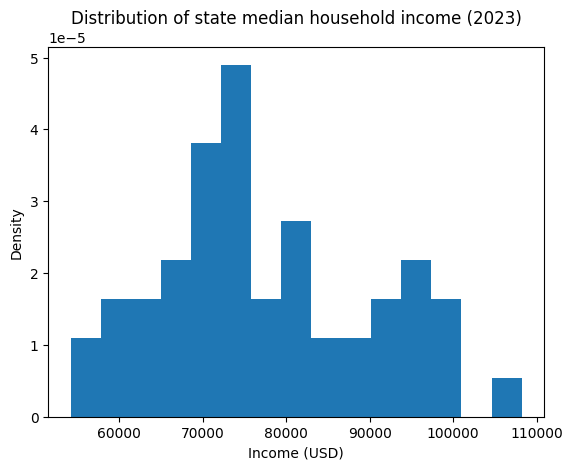

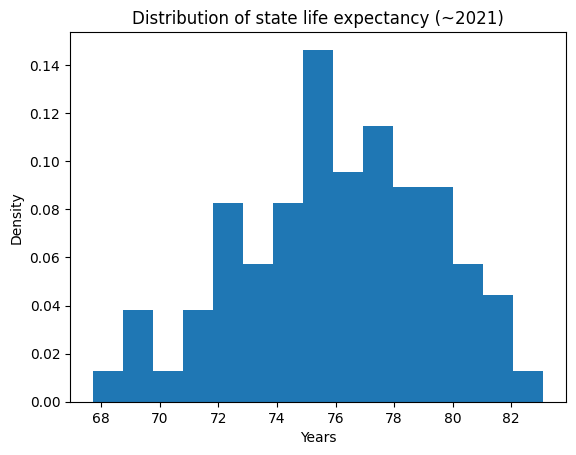

In [77]:
# Density (hist) plots — income and life expectancy (two separate figures)
plt.figure()
plt.hist(us["median_income"].dropna(), bins=15, density=True)
plt.title("Distribution of state median household income (2023)")
plt.xlabel("Income (USD)")
plt.ylabel("Density")
plt.show()

plt.figure()
plt.hist(us["leb"].dropna(), bins=15, density=True)
plt.title("Distribution of state life expectancy (~2021)")
plt.xlabel("Years")
plt.ylabel("Density")
plt.show()

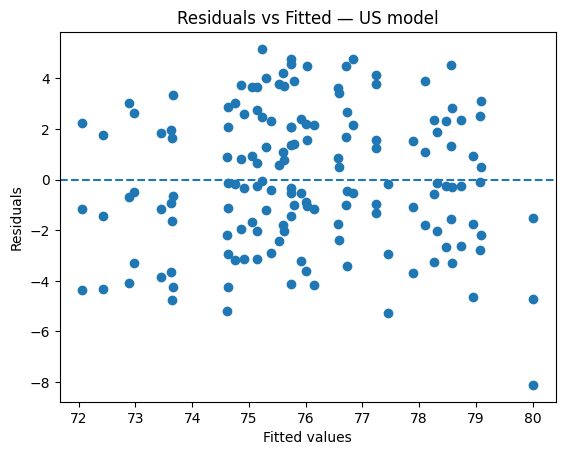

In [78]:

# Residual vs fitted (single plot)
fitted = mod.fittedvalues
resid = mod.resid

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted — US model")
plt.show()


## OECD Countries — Data acquisition & merge

In [87]:
# --- OECD median income (equivalised disposable, USD PPP), expected year ~2021 ---
# if OECD_MEDIAN_INCOME_CSV.startswith("http"):
#     oecd_inc = smart_read_tabular(OECD_MEDIAN_INCOME_CSV)
# else:
#     raise ValueError("Set OECD_MEDIAN_INCOME_CSV to the Statlink CSV URL from the OECD page.")

# Read the entire income Excel file without skipping rows or headers initially
try:
    oecd_inc_full = pd.read_excel(OECD_MEDIAN_INCOME_CSV, header=None)
except Exception as e:
    print(f"Error reading entire income Excel without skipping rows or header: {e}")
    oecd_inc_full = pd.DataFrame() # Create empty dataframe if reading fails


if not oecd_inc_full.empty:
    # Based on inspecting the full dataframe output, data starts at row 19, country is col 0, value is col 1
    data_start_row_inc = 19
    country_col_idx_inc = 0
    value_col_idx_inc = 1

    # Select the data using iloc
    if data_start_row_inc < len(oecd_inc_full) and max(country_col_idx_inc, value_col_idx_inc) < len(oecd_inc_full.columns):
        oecd_inc = oecd_inc_full.iloc[data_start_row_inc:, [country_col_idx_inc, value_col_idx_inc]].copy() # Use .copy() to avoid SettingWithCopyWarning
        print("\nIncome dataframe after selecting data with iloc:")
        print(oecd_inc.head())
        print("Columns after selecting data with iloc:", oecd_inc.columns.tolist())

        # Rename columns using the identified indices (which are now the new column names after iloc)
        oecd_inc = oecd_inc.rename(columns={oecd_inc.columns[0]: "country", oecd_inc.columns[1]: "median_income_ppp"})
        print("Income columns after renaming:", oecd_inc.columns.tolist())

        # Print head and dtypes of oecd_inc after renaming but before dropping NaNs
        print("oecd_inc after renaming but before dropping NaNs:")
        print(oecd_inc.head())
        print("Dtypes of oecd_inc after renaming:", oecd_inc.dtypes)

        # Print unique values in 'median_income_ppp' before numeric conversion
        print("\nUnique values in 'median_income_ppp' before numeric conversion:")
        print(oecd_inc["median_income_ppp"].unique())

        # Filter out rows where 'median_income_ppp' is a string containing specific non-numeric patterns
        # observed in the unique values (e.g., "Source:").
        # We will keep rows where the value is NOT a string or does NOT contain "Source:".
        initial_rows = len(oecd_inc)
        oecd_inc = oecd_inc[~oecd_inc["median_income_ppp"].astype(str).str.contains("Source:", na=False)].copy()
        rows_after_filtering = len(oecd_inc)
        print(f"\nFiltered out {initial_rows - rows_after_filtering} rows with non-numeric patterns in 'median_income_ppp'.")
        print("Income dataframe after filtering non-numeric patterns:")
        print(oecd_inc.head())


        # Convert median_income_ppp to numeric, coercing errors
        oecd_inc["median_income_ppp"] = pd.to_numeric(oecd_inc["median_income_ppp"], errors="coerce")

        # Keep only the relevant columns and drop rows with missing values in those columns
        oecd_inc_for_merge = oecd_inc[["country","median_income_ppp"]].dropna()
        print("oecd_inc_for_merge before merge:", oecd_inc_for_merge.head())
        print("Countries in oecd_inc_for_merge:", oecd_inc_for_merge["country"].tolist())

    else:
        print("Error: Data start row or column indices are out of bounds for the full income dataframe.")
        oecd_inc_for_merge = pd.DataFrame(columns=["country", "median_income_ppp"])

else:
    print("Failed to read the entire income Excel file.")
    oecd_inc_for_merge = pd.DataFrame(columns=["country", "median_income_ppp"])


# --- OECD life expectancy at birth ---
# if OECD_LIFE_EXPECTANCY_CSV.startswith("http"):
#     oecd_le = smart_read_tabular(OECD_LIFE_EXPECTANCY_CSV)
# else:
#     raise ValueError("Set OECD_LIFE_EXPECTANCY_CSV to the Statlink CSV URL from the OECD Health at a Glance page.")

# Assuming data starts after the initial metadata rows. Let's try skipping 3 rows and no header.
skip_rows_le = 3
try:
    oecd_le = pd.read_excel(OECD_LIFE_EXPECTANCY_CSV, skiprows=skip_rows_le, header=None)
except Exception as e:
    print(f"Error reading life expectancy Excel with skiprows={skip_rows_le} and header=None: {e}")
    # If skipping doesn't work, try reading without skipping to inspect
    oecd_le = pd.read_excel(OECD_LIFE_EXPECTANCY_CSV)
    print("Attempting to read life expectancy Excel without skipping rows for inspection.")


print("\nColumns in oecd_le after reading Excel (potentially with skiprows and no header):", oecd_le.columns.tolist())
print("Head of oecd_le after reading Excel (potentially with skiprows and no header):\n", oecd_le.head())

# Explicitly rename the first column to country and the third column to life_expectancy
if len(oecd_le.columns) >= 3:
    country_col_le_idx = 0
    value_col_le_idx = 2 # Assuming life expectancy is in the third column (index 2)

    oecd_le = oecd_le.rename(columns={country_col_le_idx: "country", value_col_le_idx: "life_expectancy"})
    # Print columns after renaming
    print("Life expectancy columns after renaming:", oecd_le.columns.tolist())

    # Convert life_expectancy to numeric, coercing errors
    oecd_le["life_expectancy"] = pd.to_numeric(oecd_le["life_expectancy"], errors="coerce")


    # Keep only the relevant columns and drop rows with missing values in those columns
    oecd_le_for_merge = oecd_le[["country","life_expectancy"]].dropna()
    print("oecd_le_for_merge before merge:", oecd_le_for_merge.head())
    print("Countries in oecd_le_for_merge:", oecd_le_for_merge["country"].tolist())

else:
     print(f"Error: Life expectancy dataframe has less than 3 columns after skipping rows and no header.")
     print("Please check the Excel file structure and adjust skiprows or column names if necessary.")
     oecd_le_for_merge = pd.DataFrame(columns=["country", "life_expectancy"]) # Create empty dataframe


# Merge
oecd = pd.merge(oecd_inc_for_merge, oecd_le_for_merge, on="country", how="inner").dropna()
if not oecd.empty:
    oecd["log_income"] = np.log(oecd["median_income_ppp"])
    oecd.to_csv(OECD_JOINED_CSV, index=False)
    print("OECD merged dataframe head:", oecd.head())
else:
    print("OECD merged dataframe is empty.")


Income dataframe after selecting data with iloc:
           0             1
19     Italy  27949.214348
20  Slovenia  28697.900661
21    France  30622.362007
22   Finland  30726.570182
23   Ireland  31392.192427
Columns after selecting data with iloc: [0, 1]
Income columns after renaming: ['country', 'median_income_ppp']
oecd_inc after renaming but before dropping NaNs:
     country median_income_ppp
19     Italy      27949.214348
20  Slovenia      28697.900661
21    France      30622.362007
22   Finland      30726.570182
23   Ireland      31392.192427
Dtypes of oecd_inc after renaming: country              object
median_income_ppp    object
dtype: object

Unique values in 'median_income_ppp' before numeric conversion:
[27949.21434835851 28697.900660874315 30622.36200729522 30726.570181642546
 31392.192427298665 31881.752648626323 32158.178594992904
 33471.53348191303 34061.23725133441 35536.522695361346 35891.17794846027
 36834.837309757815 36852.79573474401 37110.44121412388 37714.84

In [ ]:
#I want to upload the dataset files to this colab notebook.


In [83]:
# Instructions for uploading files:
# 1. Click on the folder icon on the left sidebar to open the "Files" pane.
# 2. Click on the "Upload to session storage" icon (the first icon in the Files pane toolbar).
# 3. Select the files from your local computer and click "Open".
#
# After uploading, update the file paths in cell azt-SoBb9GTN to point to the uploaded files.
# For example:
# OECD_MEDIAN_INCOME_CSV = "/content/Median_income_2023.xlsx"
# OECD_LIFE_EXPECTANCY_CSV = "/content/life_expectancy_2021.xlsx"

## OECD — OLS regression & plots

In [88]:
print("Columns in oecd before recalculating log_income:", oecd.columns.tolist())
# Ensure log_income column exists just before OLS
if "median_income_ppp" in oecd.columns:
    oecd["log_income"] = np.log(oecd["median_income_ppp"])
    print("Recalculated log_income column.")
else:
    print("Error: 'median_income_ppp' column not found in oecd dataframe. Cannot calculate log_income.")


print("Columns in oecd before OLS:", oecd.columns.tolist())
print("Head of oecd before OLS:\n", oecd.head())


Xc = sm.add_constant(oecd["log_income"])
yc = oecd["life_expectancy"]
modc = sm.OLS(yc, Xc).fit(cov_type="HC1")
print(modc.summary())

Columns in oecd before recalculating log_income: ['country', 'median_income_ppp', 'life_expectancy', 'log_income']
Recalculated log_income column.
Columns in oecd before OLS: ['country', 'median_income_ppp', 'life_expectancy', 'log_income']
Head of oecd before OLS:
     country  median_income_ppp  life_expectancy  log_income
0     Italy       27949.214348             82.7   10.238144
1  Slovenia       28697.900661             80.7   10.264579
2    France       30622.362007             82.4   10.329486
3   Finland       30726.570182             81.9   10.332883
4   Ireland       31392.192427             82.4   10.354314
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     73.38
Date:                Sun, 10 Aug 2025   Prob (F-statistic

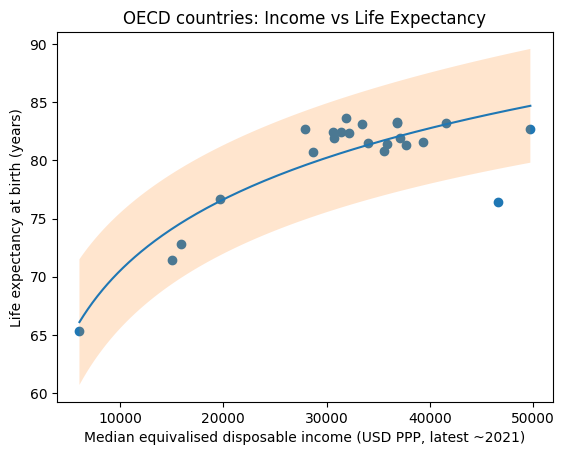

In [89]:

# Scatter + regression line with 95% CI (single plot)
xgrid = np.linspace(oecd["log_income"].min(), oecd["log_income"].max(), 200)
pred = modc.get_prediction(sm.add_constant(xgrid))
pred_df = pred.summary_frame(alpha=0.05)
x_income = np.exp(xgrid)

plt.figure()
plt.scatter(oecd["median_income_ppp"], oecd["life_expectancy"])
plt.plot(x_income, pred_df["mean"])
plt.fill_between(x_income, pred_df["obs_ci_lower"], pred_df["obs_ci_upper"], alpha=0.2)
plt.xlabel("Median equivalised disposable income (USD PPP, latest ~2021)")
plt.ylabel("Life expectancy at birth (years)")
plt.title("OECD countries: Income vs Life Expectancy")
plt.show()


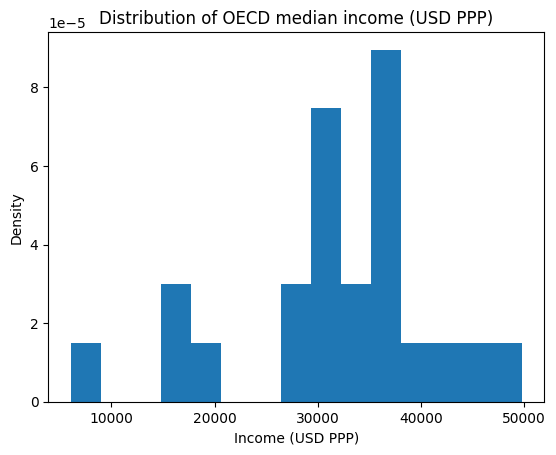

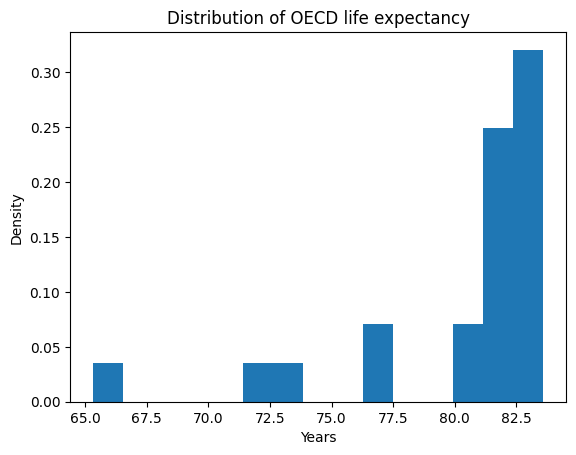

In [90]:

# Density (hist) plots (two separate figures)
plt.figure()
plt.hist(oecd["median_income_ppp"].dropna(), bins=15, density=True)
plt.title("Distribution of OECD median income (USD PPP)")
plt.xlabel("Income (USD PPP)")
plt.ylabel("Density")
plt.show()

plt.figure()
plt.hist(oecd["life_expectancy"].dropna(), bins=15, density=True)
plt.title("Distribution of OECD life expectancy")
plt.xlabel("Years")
plt.ylabel("Density")
plt.show()


## Interpretation scaffold


**Suggested steps:**
1. Report the slope (β1) and interpret: a 1% increase in median income is associated with how many years increase in life expectancy?
2. Provide **R²** and 95% CI for β1.
3. Discuss residual diagnostics (patterns in residual vs fitted plot).
4. Identify any influential outliers and consider robustness checks.
5. Note timing mismatch and unobserved confounding (smoking, obesity, education).
6. Conclude whether the data support H1 over H0.

**Next extensions (optional):**
- Add controls (smoking prevalence, obesity, education) to check robustness.
- Try winsorizing extreme income values and refitting.


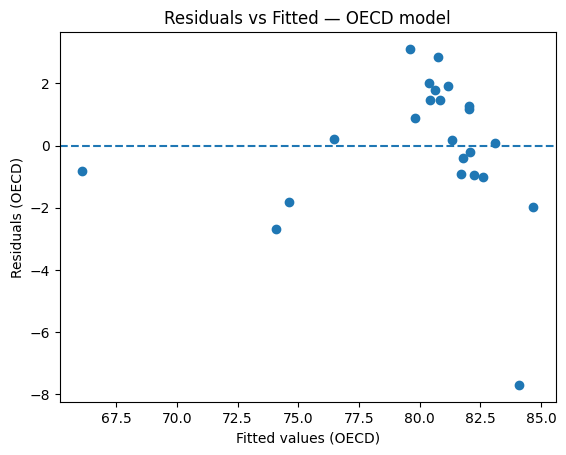

In [94]:
# Residual vs fitted for OECD (single plot)
fitted_c = modc.fittedvalues
resid_c = modc.resid

plt.figure()
plt.scatter(fitted_c, resid_c)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values (OECD)")
plt.ylabel("Residuals (OECD)")
plt.title("Residuals vs Fitted — OECD model")
plt.show()